In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.stats import shapiro
from scipy import stats
from scipy.special import inv_boxcox

In [67]:
#%% In[4]
#On crée la fonction pour tester les corr respectives pour modèle VAR
def grangers_test(data, lag, test='ssr_chi2test',verbose=False):    
    """Les valeurs dans le df sont les p-valeurs
    L'hypothèse H0 de notre test est la suivant :
        "Les prédictions de la série X n'influence pas les prédictions de la série Y"
    Ce qui signifie qu'une p-valeur inférieure à 0.05 rejette l'hypothèse H0 et incite à garder ce couple de valeurs
    Comme on s'intéresse à la prédiciton de la variable 1, on ne va jamais l'abandonner

Les arguments sont :
    Data, le DF de nos valeurs
    maxlag, le fameux maxlag pour le nombre de paramètres dans l'équation'
    variables : une list qui contient le nom des variables c'est à dire le nom de nos colonnes'
    """
    df = pd.DataFrame(np.zeros((len(data.columns), len(data.columns))), columns=data.columns, index=data.columns)
    for col in df.columns:
        for row in df.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=[lag], verbose=False)
            p_values = round(test_result[lag][0][test][1],4) #on va avoir toutes les p-valeurs une part lag
            p_value = np.min(p_values) #On s'intéresse à la valeur minimale des p-valeur
            df.loc[row, col] = p_value
    df.columns = [var for var in data.columns]
    df.index = [var + '_Y' for var in data.columns]
    return df

#Fonction test stationarité
def dickey_fuller_test(data, seuil_signif=0.05, name='', verbose=False):
    """On conduit un test de Dick-Fuller sur notre data set et on imprime les résultats"""
    """On rappelle que pour rejeter l'hypothèse H0 il faut que la p-value soit inférieur au seuil choisi, ici 0.05"""
    result = adfuller(data, autolag='BIC')
    output = {'statistique_du_test':round(result[0], 4), 'p_value':round(result[1], 4), 'n_lags':round(result[2], 4), 'n_obs':result[3]}
    p_value = output['p_value'] 

    # Print Summary
    print(f'    Test de Dick-Fuller augmenté sur : "{name}"', "\n   ", '~'*47)
    print(f' Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.')
    print(f' La p-value est de      : {p_value}')
    print(f' Niveau de confiance    = {seuil_signif}')
    print(f' Statistique de test    = {output["statistique_du_test"]}')
    print(f' Nombre de lags choisis = {output["n_lags"]}')

    if p_value <= seuil_signif:
        print(f" => P-Value = {p_value} <= {seuil_signif}. On rejette H0 au seuil de confiance.")
        print(f" => La série est STATIONNAIRE.")
    else:
        print(f" => P-Value = {p_value} > {seuil_signif}. On ne peut pas rejeter H0 au seuil de confiance.")
        print(f" => La série est NON stationnaire.")

In [60]:
def box_cox_test(dataframe_to_test):
    """We will test for each variable if a BoxCox transform brings us more normality

    Args:
        dataframe_to_test (dataframe): the dataframe that holds our data
    """
    list_non_transformed = []
    list_box_cox = []
    for col in dataframe_to_test:
        data = dataframe_to_test[col]
        if (data < 0).values.any():
            list_non_transformed.append(col)
            continue
        fig = plt.figure()
        ax1 = fig.add_subplot(221)
        prob = stats.probplot(data, dist=stats.norm, plot=ax1)
        ax1.set_xlabel('')
        ax1.set_title('Probplot against normal distribution')

        ax21 = fig.add_subplot(222)
        ax21.hist(data)
        ax21.set_xlabel(col)
        ax21.set_title('distplot')

        # normality test
        stat, p = stats.normaltest(data)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')

        xt, _ = stats.boxcox(data)
        if not np.isfinite(xt).any():
            list_non_transformed.append(col)
            continue
        list_box_cox.append(col)
        
        ax2 = fig.add_subplot(223)
        prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
        ax2.set_title('Probplot after Box-Cox transformation')
        ax22 = fig.add_subplot(224)
        ax22.hist(xt)
        ax22.set_xlabel(col)
        ax22.set_title('distplot')

        stat, p = stats.normaltest(xt)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('Sample does not look Gaussian (reject H0)')
        
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.2, wspace=0.4)
        plt.show()
    print('*'*50 +'\n' +'*'*50)
    print(f"Les données suivantes n'ont pas pu être scaled (négatives, infinites) : {list_non_transformed}. \n Voici leur plot non transformé")
    for col in list_non_transformed:
        data = dataframe_to_test[col]
        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        prob = stats.probplot(data, dist=stats.norm, plot=ax1)
        ax1.set_xlabel('')
        ax1.set_title('Probplot against normal distribution')

        ax21 = fig.add_subplot(212)
        ax21.hist(data)
        ax21.set_xlabel(col)
        ax21.set_title('distplot')

    return list_box_cox, list_non_transformed

In [5]:
#transform boxcox on selected variables
def transfo_boxcox(dataframe_to_transform, list_features_to_transform):
    dict_lambda = {}
    transformed = dataframe_to_transform.copy()
    for ft in list_features_to_transform:
        transformed[ft], l = stats.boxcox(dataframe_to_transform[ft])
        dict_lambda[ft] = l
    return transformed, dict_lambda

In [6]:
#Fonction plotting historique, True, Pred
def plot_pred_true(y_pred, y_true):
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
    test_pred, = ax.plot(date_du_split, y_pred, color = "b")
    test_test, = ax.plot(date_du_split, y_true, color = "g")
    ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
    fig.show()
    return plt.savefig("resultat.png")

def plot_pred_true_total(y_pred, y_true):
    date_list = df.index.tolist() + date_du_split.tolist()
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(15,10), dpi = 80)
    test_pred, = ax.plot(date_du_split, y_pred, color = "b")
    test_test, = ax.plot(date_totale, variable_cible, color = "g")
    ax.legend((test_pred, test_test), ("prediction", "réel"), loc = "upper left")
    fig.show()
    return plt.savefig("Historique et true VS prédiction.png")

In [7]:
#pour detransfo data :
def inv_diff(df_train, df_forecast, n_jour_cible, second_diff = False):
    df_fc_inv = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        """
        Attention ! lorsque l'on inverse une différenciation, un récupère la "dernière donnée" à laquelle on rajoute
        la somme cumulée des valeurs différenciées.
        Dans le cas d'un array prédit, le dernier point de donnée n'est PAS le "-1" du train_set, mais le "-1-nb_jour_pred"
        Dans notre cas on va donc retourner 120 jours en arrière
        Dans le cas d'une double diff, on soustrait d'abord l'avant dernière valeur à la dernière
        """
        if second_diff:
            df_fc_inv[str(col)+'_1d'] = (df_train[col].iloc[-n_jour_cible-1]-df_train[col].iloc[-n_jour_cible-2]) + df_fc_inv[str(col)].cumsum()
            df_fc_inv[str(col)+'_forecast'] = df_train[col].iloc[-n_jour_cible-1] + df_fc_inv[str(col)+"_1d"].cumsum()
        else:
            df_fc_inv[str(col)+'_forecast'] = df_train[col].iloc[-n_jour_cible-1] + df_fc_inv[str(col)].cumsum()
    return df_fc_inv

# I. Data loading & quick prep

## a. Loading

In [8]:
df = pd.read_csv("C:/Users/vdistefano/Desktop/projet_dev_perso/Article_VAR_FR_Public/historic_demand_2009_2023_noNaN.csv")
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df = df.set_index('settlement_date')
df = df.drop(['settlement_period', 'period_hour'], axis = 1)
exog = df['is_holiday']
df = df.drop(['is_holiday'], axis =1)

## b. Parameters

In [9]:
target_variable = "tsd"
index_df = df.index
n_period_predict = 48 * 7

## c. Prep/Cleaning

In [10]:
mask = (df.index > '2022-01-01')
df_pour_var = df.loc[mask]
exog_pour_var = exog.loc[mask]
df_pour_var = df_pour_var +1

## d. BoxCox transformation ?

Statistics=983.597, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=1088.874, p=0.000
Sample does not look Gaussian (reject H0)


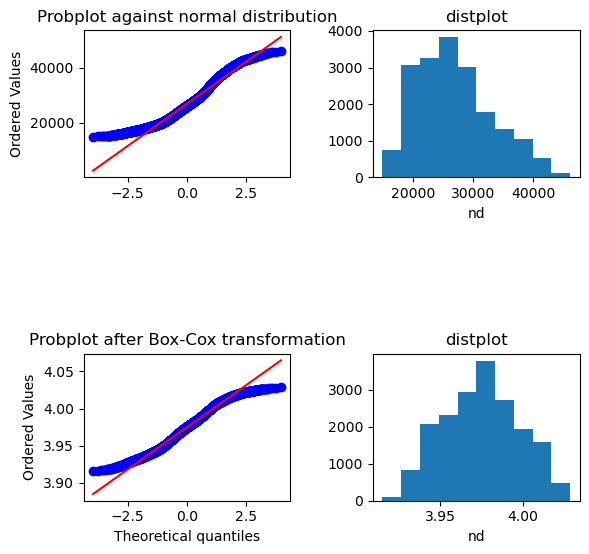

Statistics=932.552, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=321.045, p=0.000
Sample does not look Gaussian (reject H0)


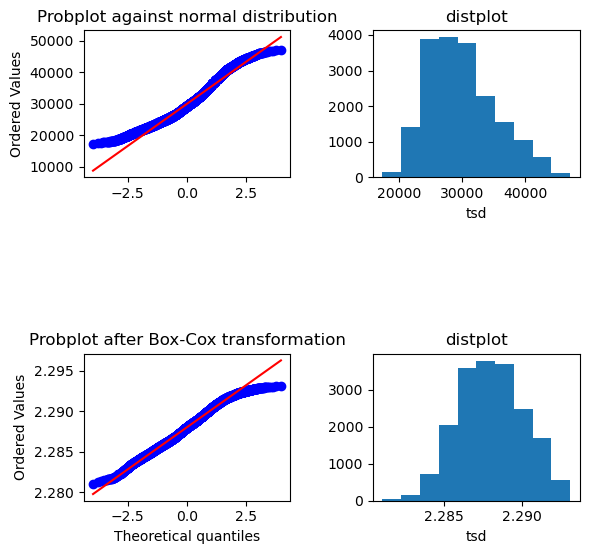

Statistics=1013.847, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=698.804, p=0.000
Sample does not look Gaussian (reject H0)


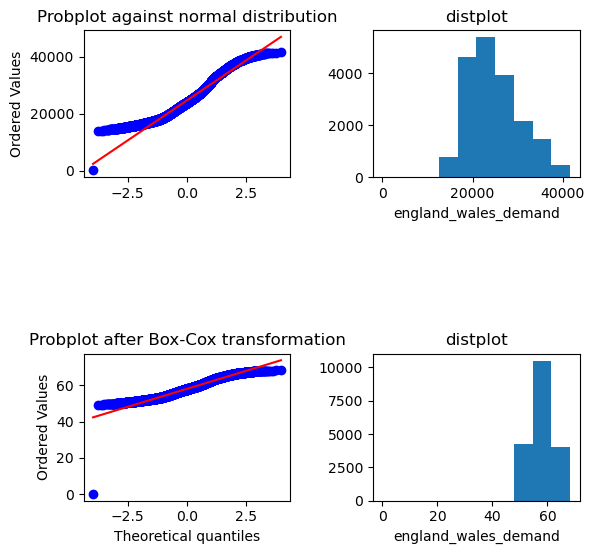

Statistics=1340.080, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=1718.151, p=0.000
Sample does not look Gaussian (reject H0)


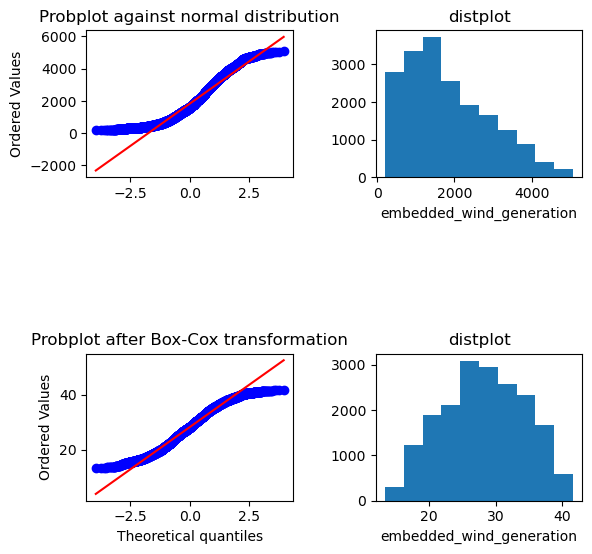

Statistics=6126.835, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=4797.237, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=70144.857, p=0.000
Sample does not look Gaussian (reject H0)


c:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\scipy\stats\_morestats.py:933: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
c:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


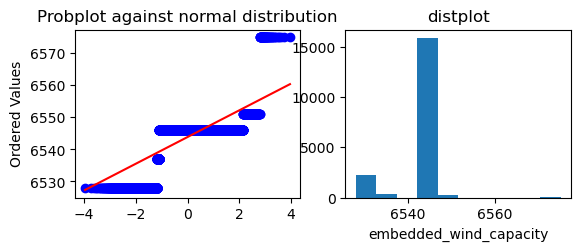

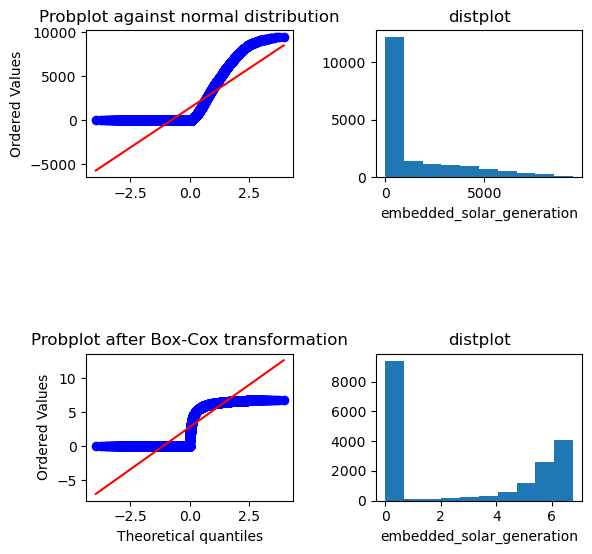

Statistics=10984.778, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=nan, p=nan
Sample does not look Gaussian (reject H0)


c:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
c:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\scipy\stats\_stats_py.py:1205: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
c:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\scipy\stats\_stats_py.py:1203: RuntimeWarning: overflow encountered in square
  s = s**2


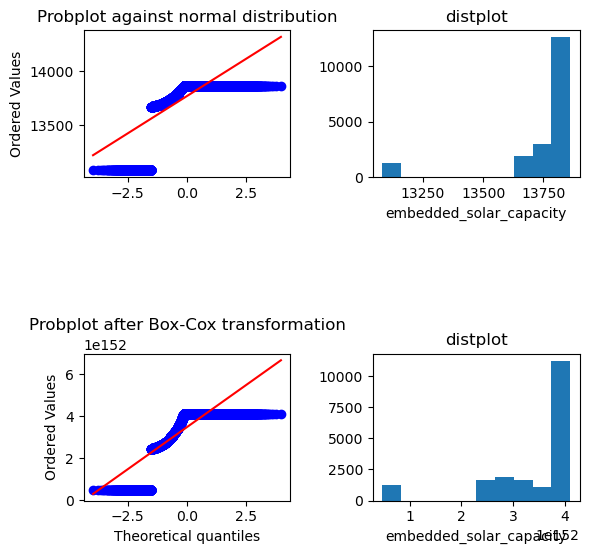

Statistics=61494.602, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=54857.241, p=0.000
Sample does not look Gaussian (reject H0)


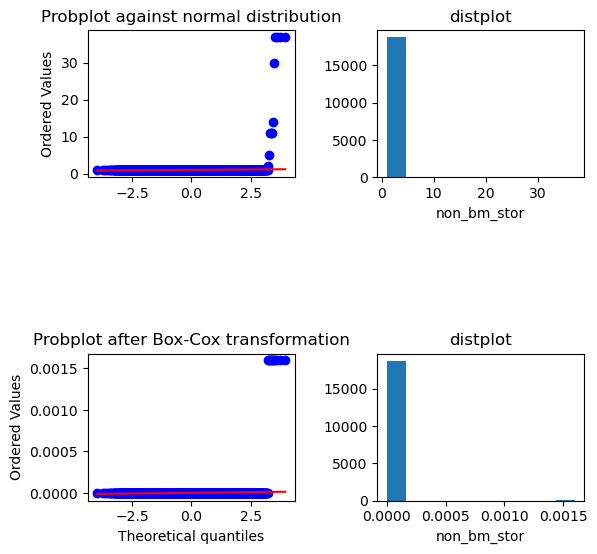

Statistics=5310.740, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=1333.940, p=0.000
Sample does not look Gaussian (reject H0)


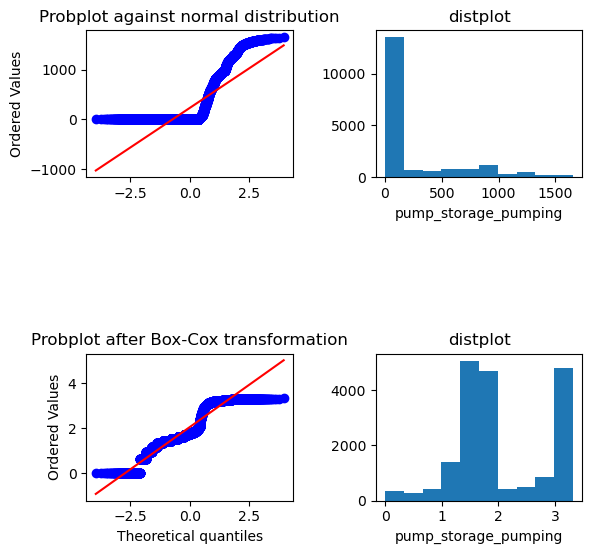

**************************************************
**************************************************
Les données suivantes n'ont pas pu être scaled (négatives, infinites) : ['embedded_wind_capacity', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow']. 
 Voici leur plot non transformé


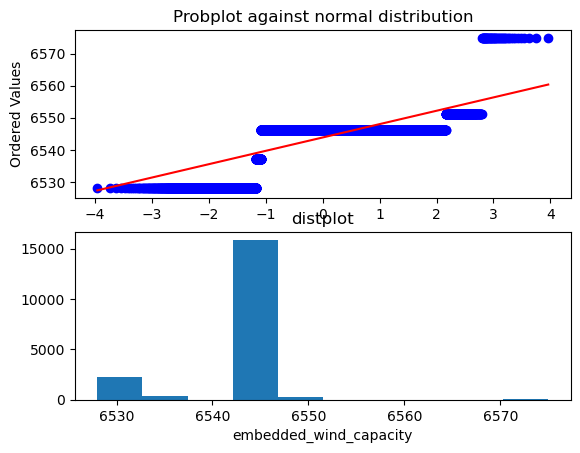

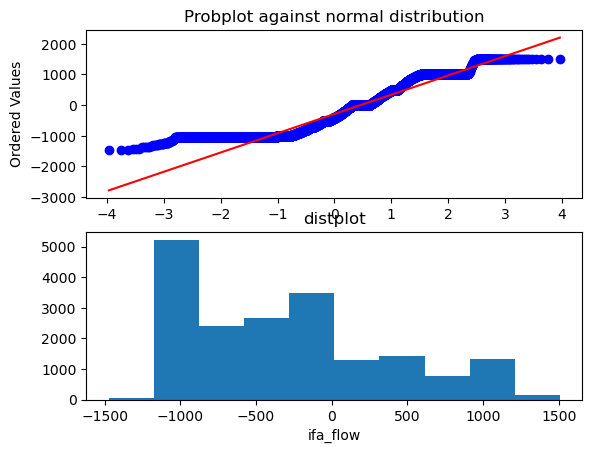

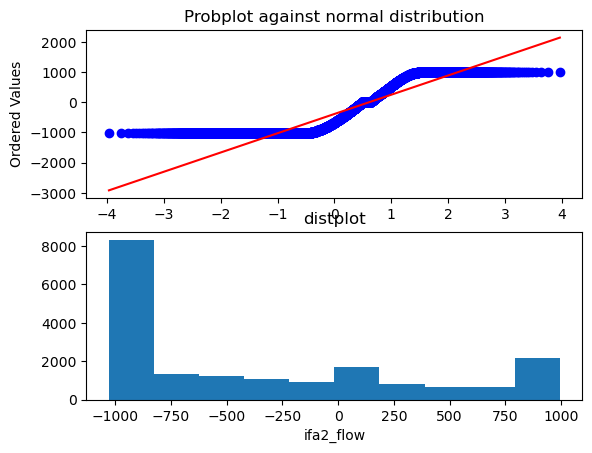

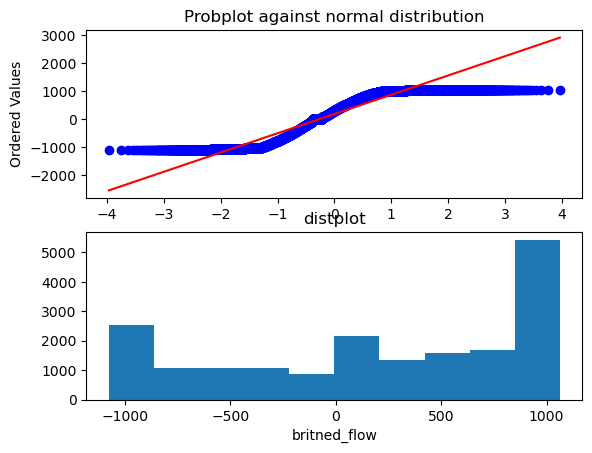

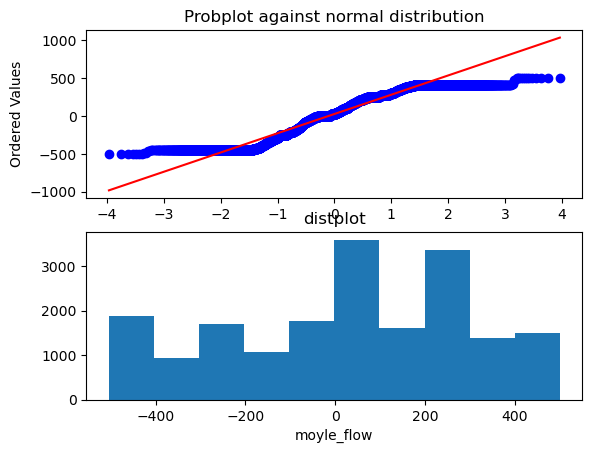

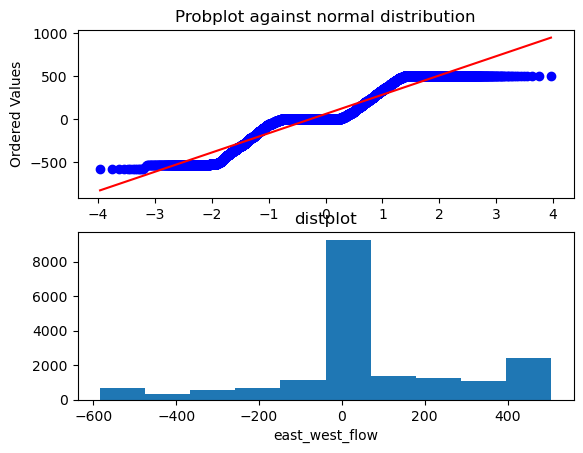

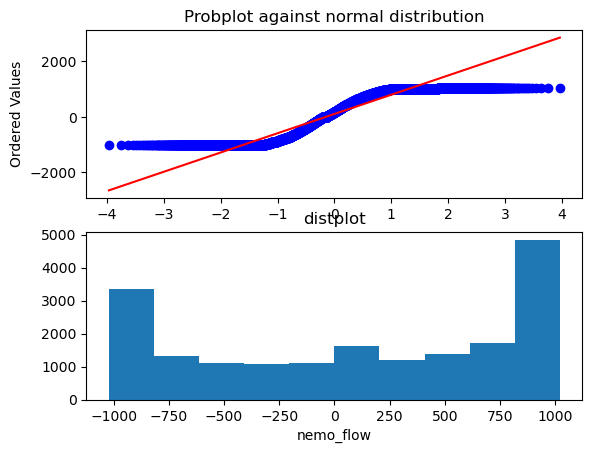

In [11]:
list_features_to_box_cox, list_features_non_box_cox = box_cox_test(df_pour_var)

transform box cox

In [12]:
df_var_transformed, dict_lambda_bc = transfo_boxcox(df_pour_var, list_features_to_box_cox)

In [13]:
#We apply a minmaxscaler transform to the data we could not transform thanks to boxcox
minmaxscaler = MinMaxScaler()
minmaxscaler = minmaxscaler.fit(df_pour_var[list_features_non_box_cox])
df_var_transformed[list_features_non_box_cox] = minmaxscaler.transform(df_pour_var[list_features_non_box_cox])

## e. Diff needed ?

In [14]:
for name, column in df_var_transformed.iteritems():
    dickey_fuller_test(column, name=column.name)
    print('\n')

C:\Users\vdistefano\AppData\Local\Temp\ipykernel_13216\236789988.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_var_transformed.iteritems():


    Test de Dick-Fuller augmenté sur : "nd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0111
 Niveau de confiance    = 0.05
 Statistique de test    = -3.3961
 Nombre de lags choisis = 45
 => P-Value = 0.0111 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "tsd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0009
 Niveau de confiance    = 0.05
 Statistique de test    = -4.1197
 Nombre de lags choisis = 45
 => P-Value = 0.0009 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "england_wales_demand" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est No

In [73]:
df_diff_1 = df_pour_var.diff().dropna()
for name, column in df_diff_1.iteritems():
    dickey_fuller_test(column, name=column.name)
    print('\n')

C:\Users\vdistefano\AppData\Local\Temp\ipykernel_13216\3849158888.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_diff_1.iteritems():


    Test de Dick-Fuller augmenté sur : "nd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0
 Niveau de confiance    = 0.05
 Statistique de test    = -27.2299
 Nombre de lags choisis = 45
 => P-Value = 0.0 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "tsd" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationnaire.
 La p-value est de      : 0.0
 Niveau de confiance    = 0.05
 Statistique de test    = -32.6588
 Nombre de lags choisis = 45
 => P-Value = 0.0 <= 0.05. On rejette H0 au seuil de confiance.
 => La série est STATIONNAIRE.


    Test de Dick-Fuller augmenté sur : "england_wales_demand" 
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Hypothèse H0: La data présente une racine unitaire, la série est Non-Stationn

Everything is now stationary ! We can go on :)

# II. Input' selection

## a. Maxlag' selection

In [16]:
maxlag = 48*7

# III. Train

In [17]:
train_var = df_diff_1[:-n_period_predict]
exog_pour_var_train = exog_pour_var[1:-n_period_predict]
test_var = df_diff_1[-n_period_predict:]
exog_pour_var_test = exog_pour_var[-n_period_predict:]

train_var.values[-maxlag:].shape
model_var = VAR(endog = train_var, exog = exog_pour_var_train)
model_var = model_var.fit(maxlags=48*7, ic = "bic")
result_normality = model_var.test_normality().pvalue #"H0 : les données suivent une loi normale. Si p-value <0.05, on rejette
result_whiteness = model_var.test_whiteness(round((len(train_var) + len(test_var))/5)).pvalue

c:\Users\vdistefano\Anaconda3\envs\VAR\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


what if the BIC is minimized but the error is not ?

<AxesSubplot: >

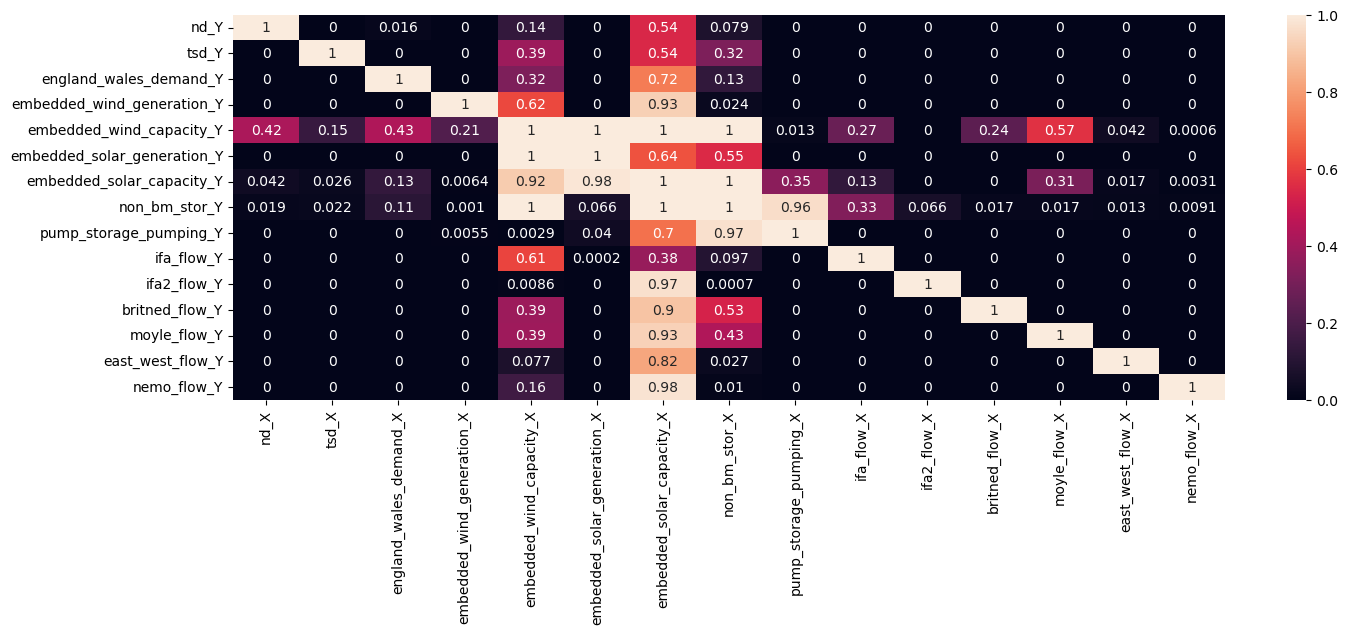

In [20]:
df_granger = grangers_test(df_diff_1, lag = model_var.k_ar)
plt.figure(figsize = (16,5))
sns.heatmap(df_granger, annot = True)

embedded_solar_capacity
12.671299999999999
embedded_wind_capacity
8.8282
non_bm_stor
4.8295
embedded_solar_generation
0.30839999999999995
england_wales_demand
0.0158
embedded_wind_generation
0.0068


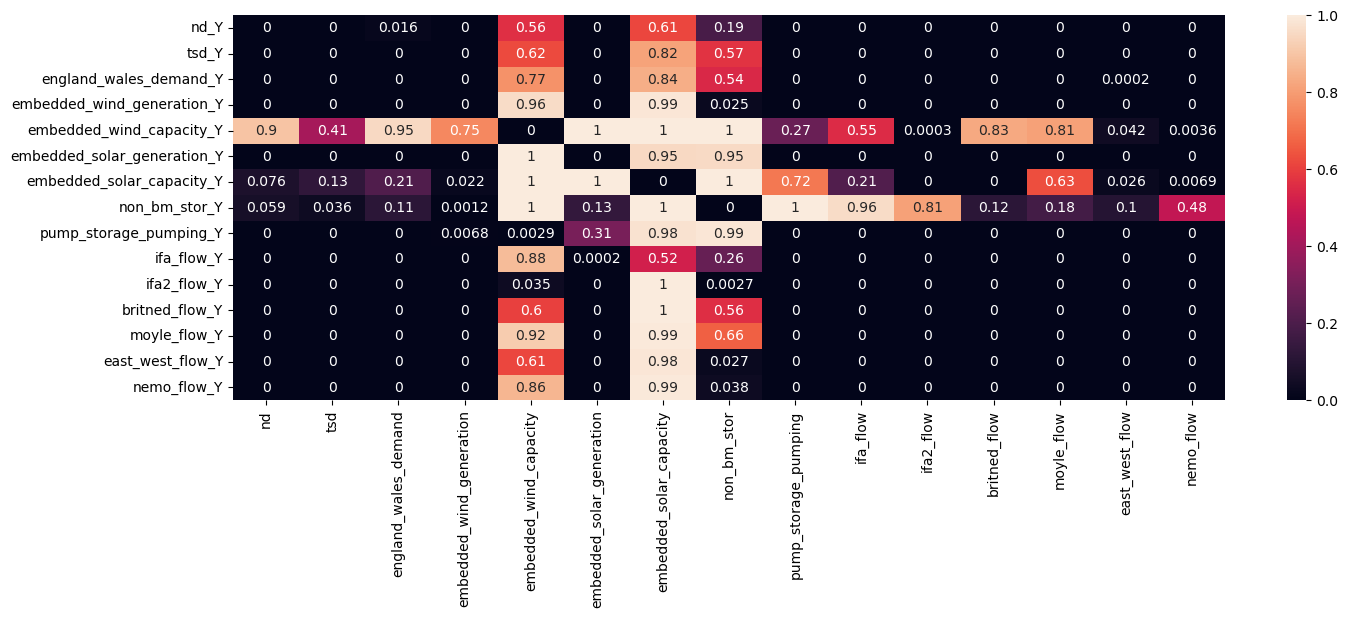

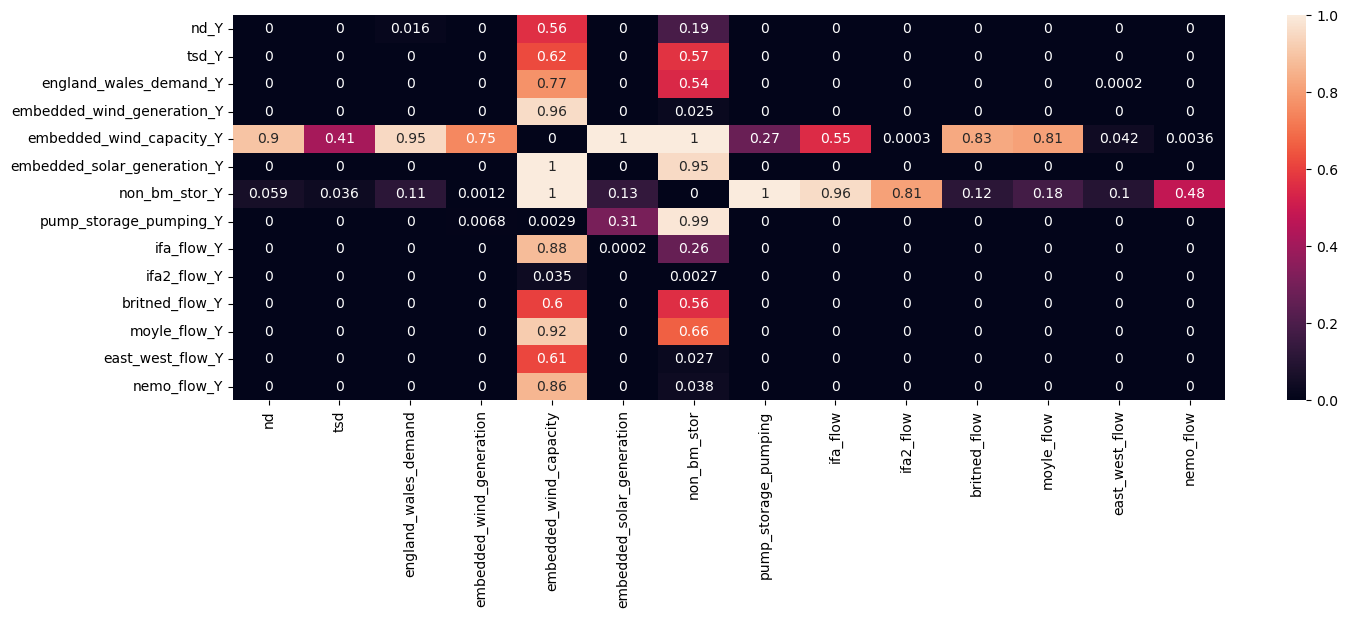

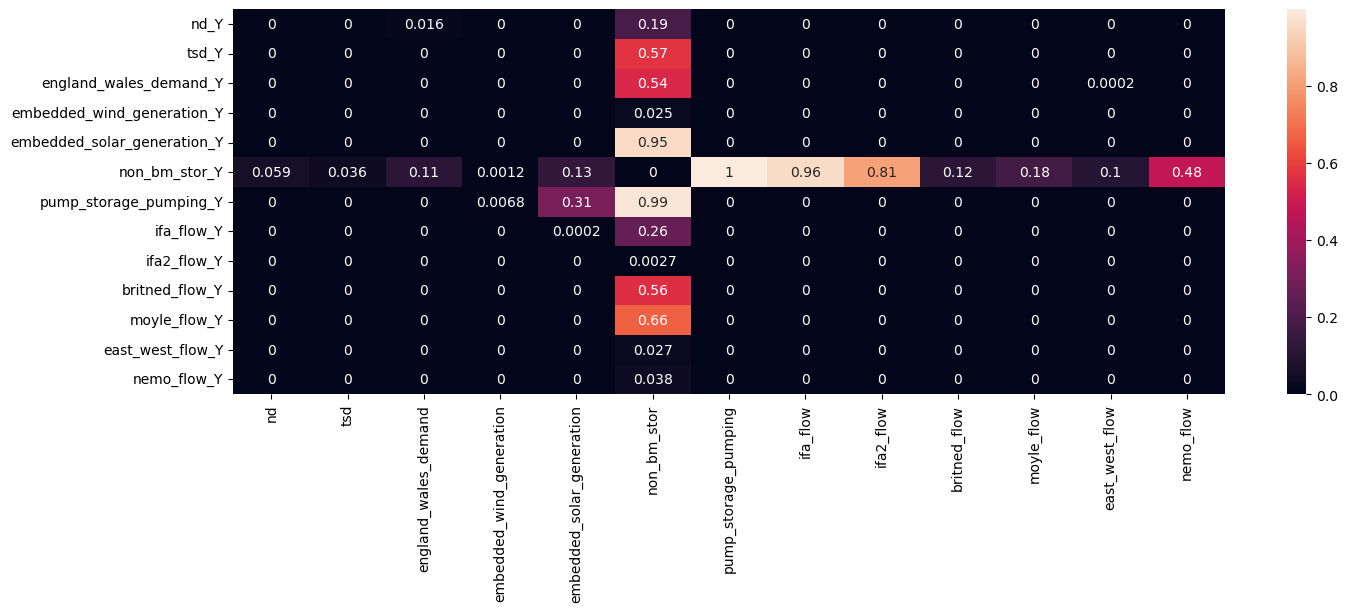

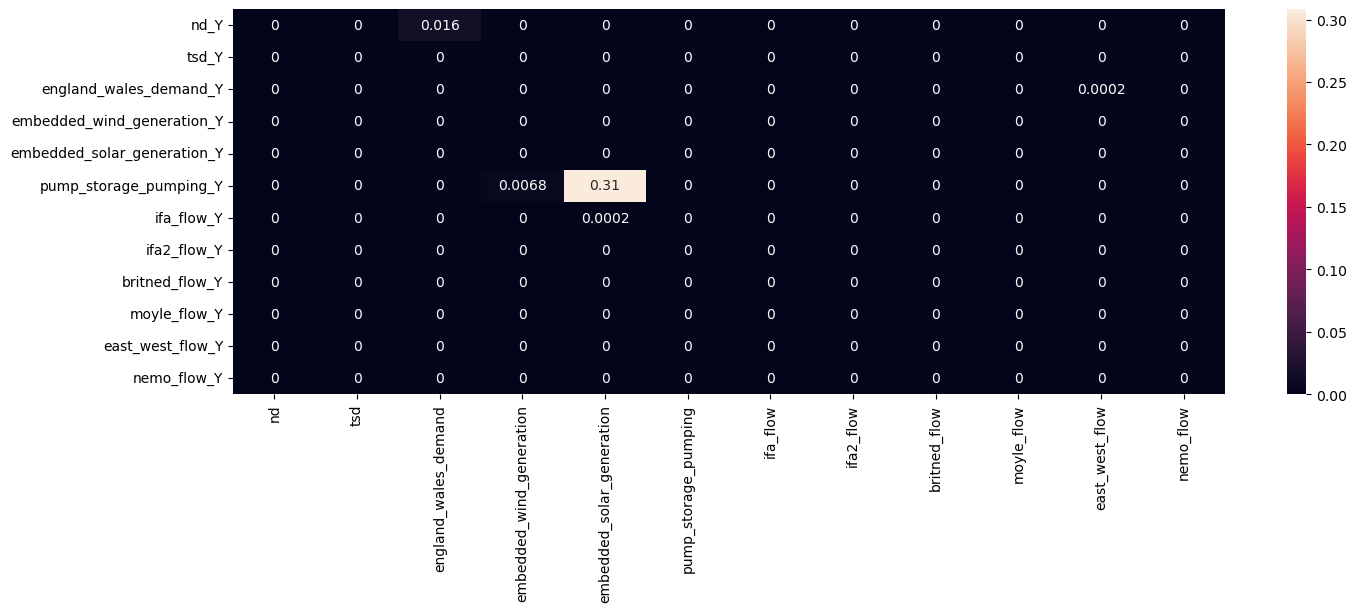

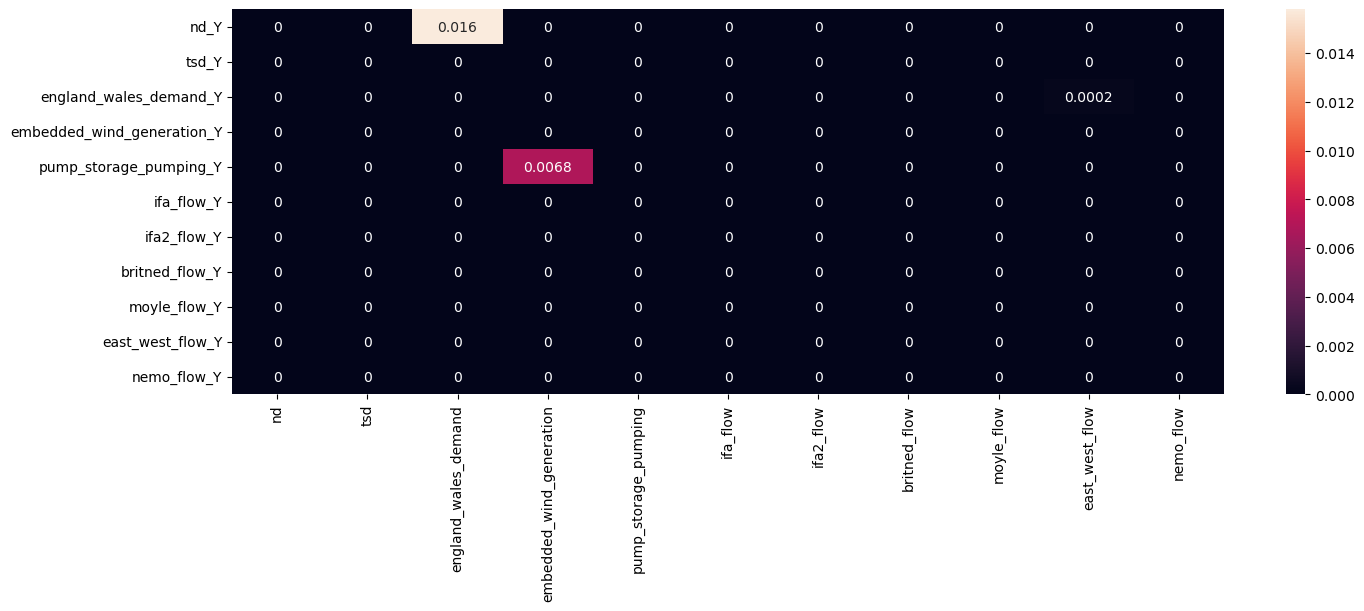

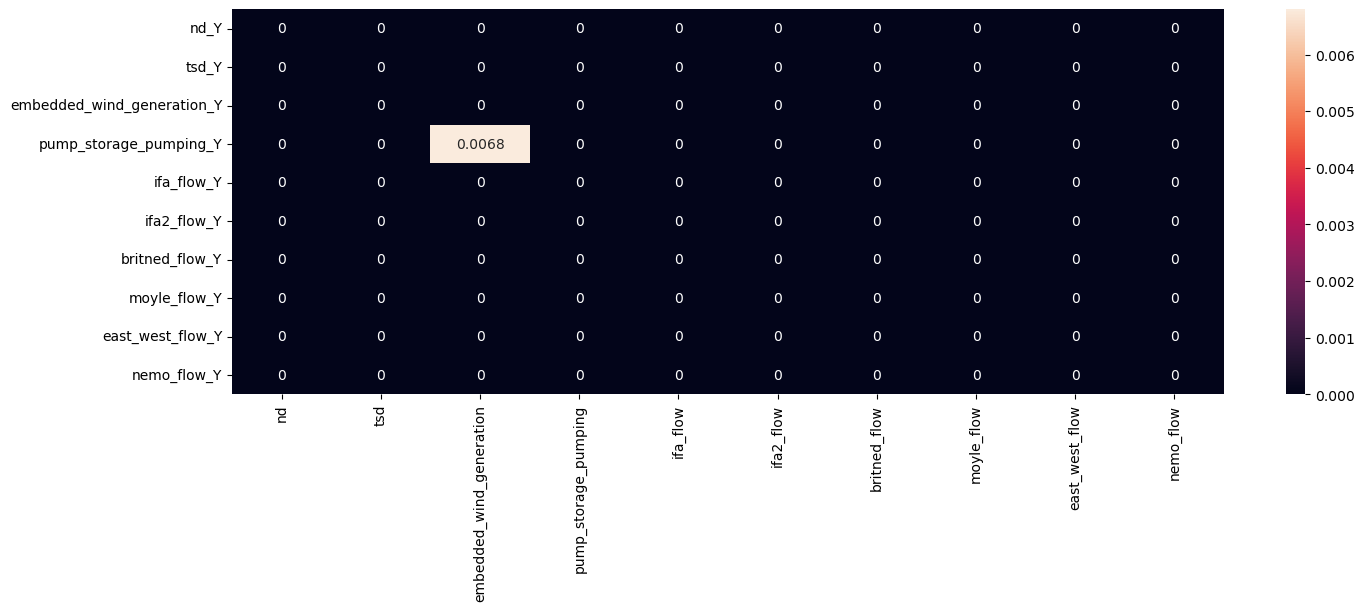

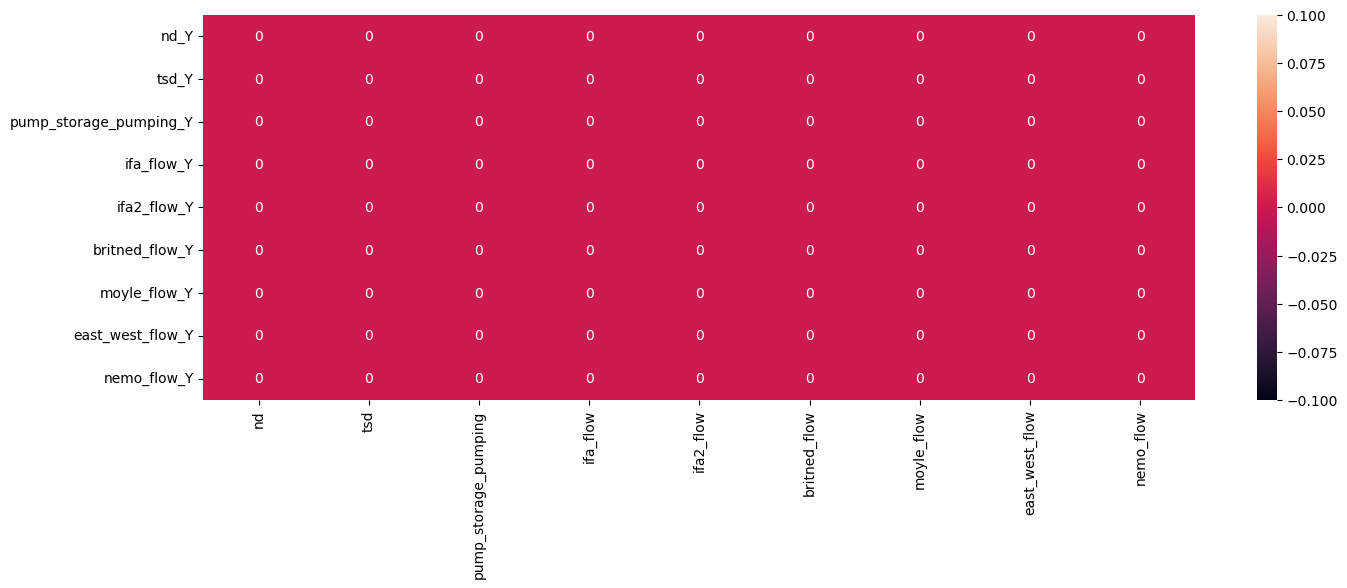

In [77]:
df_diff_1 = df_pour_var.diff().dropna()
df_granger = grangers_test(df_diff_1, lag = model_var.k_ar)
np.fill_diagonal(df_granger.values, 0)
plt.figure(figsize = (16,5))
sns.heatmap(df_granger, annot = True)
while df_granger.values.any() >= 0.05:
    list_feature_non_granger_causal = []
    list_value_non_granger_causal = []
    for col in df_granger.columns:
        if any(df_granger[col].values) >= 0.05 and col != 'nd_X':
            list_feature_non_granger_causal.append(col)
            list_value_non_granger_causal.append(sum(df_granger[col].values))
    df_feature_to_pop = pd.DataFrame(list_value_non_granger_causal, index = list_feature_non_granger_causal, columns=['p-value'])  
    print(df_feature_to_pop['p-value'].idxmax())
    print(df_feature_to_pop['p-value'].max())
    df_diff_1 = df_diff_1.drop(df_feature_to_pop['p-value'].idxmax(), axis = 1)
    df_granger = grangers_test(df_diff_1, lag = model_var.k_ar)
    np.fill_diagonal(df_granger.values, 0)
    plt.figure(figsize = (16,5))
    sns.heatmap(df_granger, annot = True)

# IV. Predict

lag_order = model_var.k_ar
input_data = train_var.values[-lag_order:]
y_predicted = model_var.forecast(y = input_data, steps = len(test_var))

df_predicted = pd.DataFrame(y_predicted, index=test_var.index, columns=train_var.columns)

# V. De-transformation

df_true_results = inv_diff(df_pour_var, df_predicted, n_period_predict)

MAE_var = mean_absolute_error(df_pour_var[variable_cible.name].iloc[-n_period_predict:], df_true_results[variable_cible.name+'_forecast'])